In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.nn.utils import clip_grad_norm_

# Load Feature Data:

In [2]:
# File path
file_path = 'features_batch_2.csv'  # Replace with your actual file path

# Load the data
data = np.loadtxt(file_path, delimiter=',')

# Split the data into features and normalize
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Split into train and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(normalized_data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_dataset = torch.FloatTensor(train_data)
val_dataset = torch.FloatTensor(val_data)

# Print shapes to verify
print(f"Training set shape: {train_dataset.shape}")
print(f"Validation set shape: {val_dataset.shape}")

# Save the datasets (optional)
torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')

# If you want to save the scaler for later use (e.g., for test data or new data)
import joblib
joblib.dump(scaler, 'scaler.pkl')

print("Data preparation completed!")

Training set shape: torch.Size([276797, 78])
Validation set shape: torch.Size([69200, 78])
Data preparation completed!


# Define Encoder

In [26]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder and Decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_log_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Initialise parameters

In [34]:
# Hyperparameters
input_dim = 78  # 12 features * 6 bands
latent_dim = 32
batch_size = 128
num_epochs = 100
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Initialize the VAE
model = VAE(input_dim, latent_dim)

# Loss function
def loss_function(recon_x, x, mu, log_var, beta=1.0):
    # Option 1: MSE
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # Or Option 4: Normalized MSE
    # MSE = normalized_mse_loss(recon_x, x, reduction='sum')
    
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + beta * KLD

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare the data
train_loader = DataLoader(TensorDataset(train_dataset), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_dataset), batch_size=batch_size)


# Training

In [35]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

# Define the max norm for gradient clipping
max_grad_norm = 1.0  

# Custom normalised MSE loss
# def normalized_mse_loss(recon_x, x, reduction='sum'):
#     mse = F.mse_loss(recon_x, x, reduction='none')
#     normalized_mse = mse / torch.var(x)
#     if reduction == 'sum':
#         return torch.sum(normalized_mse)
#     elif reduction == 'mean':
#         return torch.mean(normalized_mse)
#     else:
#         return normalized_mse

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, log_var)
        loss.backward()
        
        clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        train_loss += loss.item()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0]
            recon_batch, mu, log_var = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var)
            val_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'lsst_vae.pth')

Epoch [1/100], Train Loss: 3526323.0957, Val Loss: 4799.9744
Epoch [2/100], Train Loss: 4703.8868, Val Loss: 3972.8718
Epoch [3/100], Train Loss: 4104.3457, Val Loss: 3543.9547
Epoch [4/100], Train Loss: 3660.7524, Val Loss: 3132.0059
Epoch [5/100], Train Loss: 3253.7534, Val Loss: 2723.9909
Epoch [6/100], Train Loss: 2811.0126, Val Loss: 2455.1626
Epoch [7/100], Train Loss: 2571.2629, Val Loss: 2343.0797
Epoch [8/100], Train Loss: 2413.6046, Val Loss: 2195.2056
Epoch [9/100], Train Loss: 2259.0892, Val Loss: 2088.6202
Epoch [10/100], Train Loss: 2121.7940, Val Loss: 1963.7068
Epoch [11/100], Train Loss: 1988.4902, Val Loss: 1875.4251
Epoch [12/100], Train Loss: 1880.6142, Val Loss: 1796.5333
Epoch [13/100], Train Loss: 1811.9674, Val Loss: 1733.7348
Epoch [14/100], Train Loss: 1729.9914, Val Loss: 1680.1366
Epoch [15/100], Train Loss: 1648.1529, Val Loss: 1598.9596
Epoch [16/100], Train Loss: 1546.0417, Val Loss: 1497.4170
Epoch [17/100], Train Loss: 1435.6074, Val Loss: 1432.8540
Epo

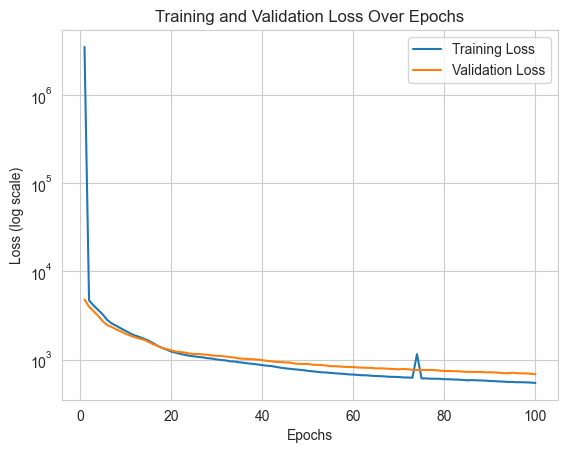

Training completed and loss plot saved as 'vae_training_loss.png'


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Plotting function
def plot_losses(train_losses, val_losses):
    # plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.yscale('log')  # Set y-axis to log scale
    plt.grid(True)
    plt.savefig('vae_training_loss.png')
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

print("Training completed and loss plot saved as 'vae_training_loss.png'")

In [37]:
# Using the trained model for encoding
def encode_data(model, data):
    model.eval()
    with torch.no_grad():
        mu, log_var = model.encode(data)
        z = model.reparameterize(mu, log_var)
    return z

# Load the trained model
loaded_model = VAE(input_dim, latent_dim)
loaded_model.load_state_dict(torch.load('lsst_vae.pth'))

# Encode the test dataset
encoded_test = encode_data(loaded_model, val_dataset)

print("Shape of encoded test data:", encoded_test.shape)

# Generate new samples
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        samples = model.decode(z)
    return samples

new_samples = generate_samples(loaded_model, 10)
print("Shape of generated samples:", new_samples.shape)

Shape of encoded test data: torch.Size([69200, 32])
Shape of generated samples: torch.Size([10, 78])


/var/folders/j1/2fc026fn1yd35x1ljyjz6k600000gn/T/ipykernel_53199/3848651775.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('lss

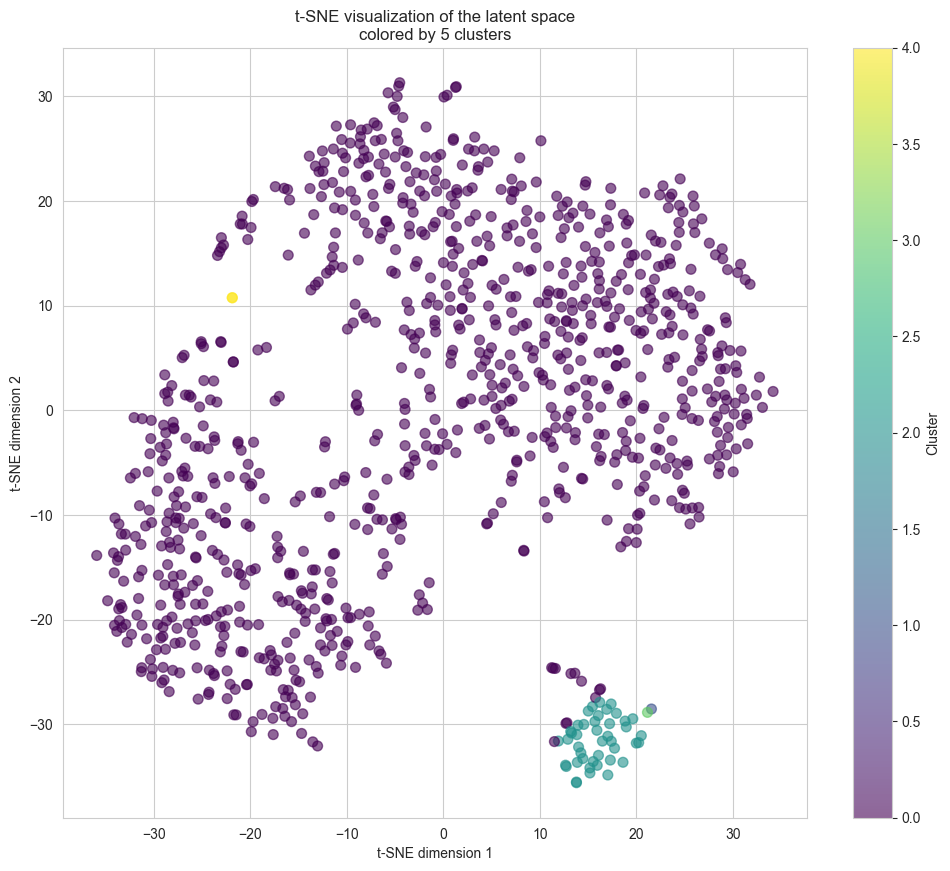

ValueError: perplexity must be less than n_samples

In [43]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


def visualize_latent_space_clustered(model, data_loader, num_samples=1000, n_clusters=5):
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if i * data_loader.batch_size >= num_samples:
                break
            if isinstance(data, (list, tuple)):
                data = data[0]
            data = data.to(next(model.parameters()).device)
            
            mu, log_var = model.encode(data)
            z = model.reparameterize(mu, log_var)
            latent_vectors.append(z)
    
    latent_vectors = torch.cat(latent_vectors, dim=0)
    latent_vectors = latent_vectors[:num_samples].cpu().numpy()

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                          c=cluster_labels, cmap='viridis', 
                          alpha=0.6, s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f"t-SNE visualization of the latent space\ncolored by {n_clusters} clusters")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

    # Plot centroids
    centroids = kmeans.cluster_centers_
    centroids_2d = tsne.fit_transform(centroids)
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                          c=cluster_labels, cmap='viridis', 
                          alpha=0.6, s=50)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                c='red', marker='x', s=200, linewidths=3)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f"t-SNE visualization of the latent space\nwith {n_clusters} cluster centroids")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

# Assuming you have a DataLoader for your validation set called val_loader
visualize_latent_space_clustered(model, val_loader, n_clusters=5)